In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata
from filterpy.kalman import KalmanFilter
from filterpy.common import Saver
from filterpy.common import Q_discrete_white_noise
%matplotlib inline
%matplotlib widget

In [2]:
# ******************** Data from Admittance Control ***************** ##
#df = pd.read_csv("/home/unknown/Documents/PostDoc/bagfiles/rosbag2_Admittance/admittance.csv") 

# ******************** Data from Admittance Control ***************** ##
# df = pd.read_csv("/home/unknown/Documents/PostDoc/bagfiles/rosbag2_Admittance/admittance.csv") 

# ******************** Data from Candle Position ***************** ##
# df = pd.read_csv("/home/unknown/Documents/PostDoc/bagfiles/rosbag2_candle/candle.csv") 

# # ******************** Data from HP ***************** ##
#df = pd.read_csv("/home/unknown/Documents/PostDoc/bagfiles/rosbag2_HP/HP.csv") 

# ******************** Data from Velocity control ***************** ##
df = pd.read_csv("/home/unknown/Documents/PostDoc/bagfiles/rosbag2_VelControl/velctrl.csv") 

# ******************** Data from angular position control ***************** ##
# df = pd.read_csv("/home/unknown/Documents/PostDoc/bagfiles/rosbag2_link2/link2.csv") 

time = df['__time']
time =  (time.values - time.values[0])

### Data from testing only joint 2 (90 degrees, 180 etc)#######################################
q1 = df['/jaco/manipulator_skillset/manipulator_skillset/joint/q1/position'].fillna(method='ffill')
q2 = df['/jaco/manipulator_skillset/manipulator_skillset/joint/q2/position'].fillna(method='ffill')
q3 = df['/jaco/manipulator_skillset/manipulator_skillset/joint/q3/position'].fillna(method='ffill')
q4 = df['/jaco/manipulator_skillset/manipulator_skillset/joint/q4/position'].fillna(method='ffill')
q5 = df['/jaco/manipulator_skillset/manipulator_skillset/joint/q5/position'].fillna(method='ffill')
q6 = df['/jaco/manipulator_skillset/manipulator_skillset/joint/q6/position'].fillna(method='ffill')

qdot1 = df['/jaco/manipulator_skillset/manipulator_skillset/joint/q1/velocity'].fillna(method='ffill')
qdot2 = df['/jaco/manipulator_skillset/manipulator_skillset/joint/q2/velocity'].fillna(method='ffill')
qdot3 = df['/jaco/manipulator_skillset/manipulator_skillset/joint/q3/velocity'].fillna(method='ffill')
qdot4 = df['/jaco/manipulator_skillset/manipulator_skillset/joint/q4/velocity'].fillna(method='ffill')
qdot5 = df['/jaco/manipulator_skillset/manipulator_skillset/joint/q5/velocity'].fillna(method='ffill')
qdot6 = df['/jaco/manipulator_skillset/manipulator_skillset/joint/q6/velocity'].fillna(method='ffill')

q1_kal = df['/jaco/manipulator_skillset/manipulator_skillset/refs_/taud1/position'].fillna(method='ffill')
q2_kal = df['/jaco/manipulator_skillset/manipulator_skillset/refs_/taud2/position'].fillna(method='ffill')
q3_kal = df['/jaco/manipulator_skillset/manipulator_skillset/refs_/taud3/position'].fillna(method='ffill')
q4_kal = df['/jaco/manipulator_skillset/manipulator_skillset/refs_/taud4/position'].fillna(method='ffill')
q5_kal = df['/jaco/manipulator_skillset/manipulator_skillset/refs_/taud5/position'].fillna(method='ffill')
q6_kal = df['/jaco/manipulator_skillset/manipulator_skillset/refs_/taud6/position'].fillna(method='ffill')

qdot1_kal = df['/jaco/manipulator_skillset/manipulator_skillset/refs_/taud1/velocity'].fillna(method='ffill')
qdot2_kal = df['/jaco/manipulator_skillset/manipulator_skillset/refs_/taud2/velocity'].fillna(method='ffill')
qdot3_kal = df['/jaco/manipulator_skillset/manipulator_skillset/refs_/taud3/velocity'].fillna(method='ffill')
qdot4_kal = df['/jaco/manipulator_skillset/manipulator_skillset/refs_/taud4/velocity'].fillna(method='ffill')
qdot5_kal = df['/jaco/manipulator_skillset/manipulator_skillset/refs_/taud5/velocity'].fillna(method='ffill')
qdot6_kal = df['/jaco/manipulator_skillset/manipulator_skillset/refs_/taud6/velocity'].fillna(method='ffill')

In [3]:
def state_observer(x_hat, z, u, dt, l1, l2):
    ys = []
    A = np.array([[1., dt],
             [0., 1.]])

    L = np.array([[l1, 0.],
                 [0, l2]])

    C = np.array([[1., 0.],
                 [0.,  1.]])

    B = np.array([0, 0.])
    for i in range(len(time)):
        x_hat = A@x_hat+ B*u[i] + L@(z[i,:] - C@x_hat)*dt
        ys.append(x_hat)
    ys = np.array(ys)
    return ys

In [4]:
def state_observer2(x_hat, z, u, dt, l1, l2):
    ys = []
    A = np.array([[1., dt],
             [0., 1.]])

    L = np.array([l1, l2])

    C = np.array([1., 0.])
    B = np.array([0, 0.])
    for i in range(len(time)):
        x_hat = A@x_hat + B*u[i]+ L*(z[i] - C@x_hat)*dt
        ys.append(x_hat)
    ys = np.array(ys)
    return ys

In [5]:
def state_observer3(x_hat, z, u, dt, l1, l2):
    ys = []
    A = np.array([[1., dt],
             [0., 1.]])

    L = np.array([l1, l2])

    C = np.array([1., 0.])
    B = np.array([0, 0.])
    for i in range(len(time)):
        x_hat = A@x_hat + L*(z[i] - C@x_hat)*dt
        ys.append(x_hat)
    ys = np.array(ys)
    return ys

In [6]:
def plot_states(q,qdot,q_kal,qdot_kal, ys, label, label2):
    fig, ax = plt.subplots()
    ax = plt.subplot(211)
    plt.plot(qdot.values,'r')
    plt.plot(qdot_kal.values, '--b')
    plt.plot(ys[:,1], ':k')
    ax.set_ylabel(r"$[deg/s]$", fontsize = 10)
    ax.legend((label[0], label[1], label[2]),loc='center left', bbox_to_anchor=(1, 0.5))
    fig.tight_layout()
    plt.grid(True)

    ax = plt.subplot(212)
    plt.plot(q.values,'r')
    plt.plot(q_kal.values, '--b')
    plt.plot(ys[:,0], ':k')
    ax.set_ylabel(r"$[deg]$", fontsize = 10)
    ax.legend((label2[0], label2[1], label2[2]),loc='center left', bbox_to_anchor=(1, 0.5))
    fig.tight_layout()
    plt.grid(True)

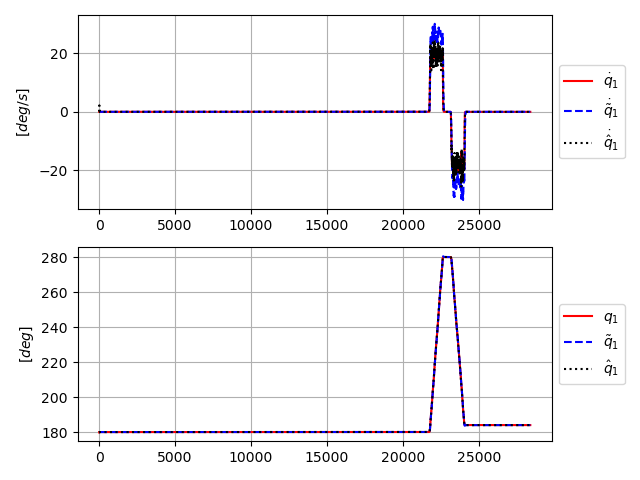

In [15]:
for i in range(len(time)):
    if np.isnan(q1[i]):
        q1[i] = 180
    
for i in range(len(time)):
    if np.isnan(qdot1[i]):
        qdot1[i] = 0
dt=0.01
u = qdot1.values
x_hat = np.array([180, 0.]).T
z = q1.values
l1, l2 = 28.2, 200
# l1, l2 = 282.74, 1.99e4
#l1, l2 = 22.5,100
y1 = state_observer3(x_hat,z,u,dt, l1, l2)
y1[:,1] = y1[:,1]*1.7
label1 = [r"$\dot{q}_1$",r"$\dot{\tilde{q}}_{1}$",r"$\dot{\hat{q}}_{1}$"]
label2 = [r"$q_1$",r"$\tilde{q}_{1}$",r"$\hat{q}_{1}$"]
plot_states(q1,qdot1, q1_kal, qdot1_kal, y1, label1, label2)

In [12]:
q3.values

array([        nan, 43.50918961, 43.50918961, ..., 72.51798248,
       72.51798248, 72.51798248])

In [ ]:
##### for i in range(len(time)):
    if np.isnan(q2[i]):
        q2[i] = 180
    
for i in range(len(time)):
    if np.isnan(qdot2[i]):
        qdot2[i] = 0
dt=0.001
u = qdot2.values
x_hat = np.array([180, 0.]).T
z = q2.values
l1, l2 = 135, 9000
y2 = state_observer2(x_hat,z,u,dt, l1, l2)
label1 = [r"$\dot{q}_2$",r"$\dot{\tilde{q}}_{2}$",r"$\dot{\hat{q}}_{2}$"]
label2 = [r"$q_2$",r"$\tilde{q}_{2}$",r"$\hat{q}_{2}$"]
plot_states(q2,qdot2, q2_kal, qdot2_kal, y2, label1, label2)

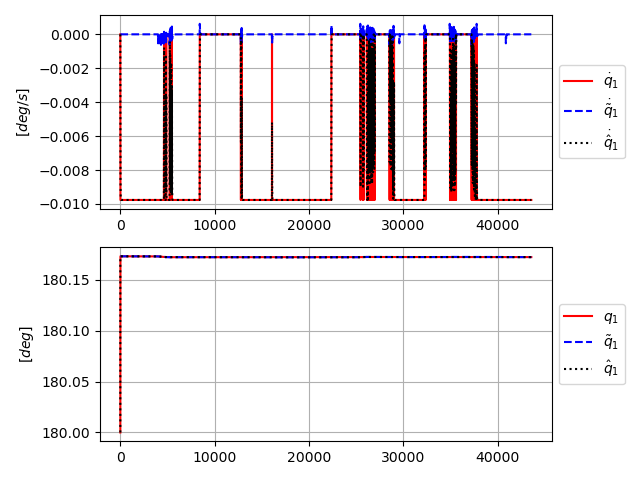

In [464]:
q1.values[0]=180
qdot1.values[0] = 0.0
dt=0.001
u = qdot1.values
x_hat = np.array([180, 0.]).T
z = np.array([q1.values, qdot1.values]).T
l1, l2 = 1000, 100
y1 = state_observer(x_hat,z,u,dt, l1, l2)
label1 = [r"$\dot{q}_1$",r"$\dot{\tilde{q}}_{1}$",r"$\dot{\hat{q}}_{1}$"]
label2 = [r"$q_1$",r"$\tilde{q}_{1}$",r"$\hat{q}_{1}$"]
plot_states(q1,qdot1, q1_kal, qdot1_kal, y1, label1, label2)

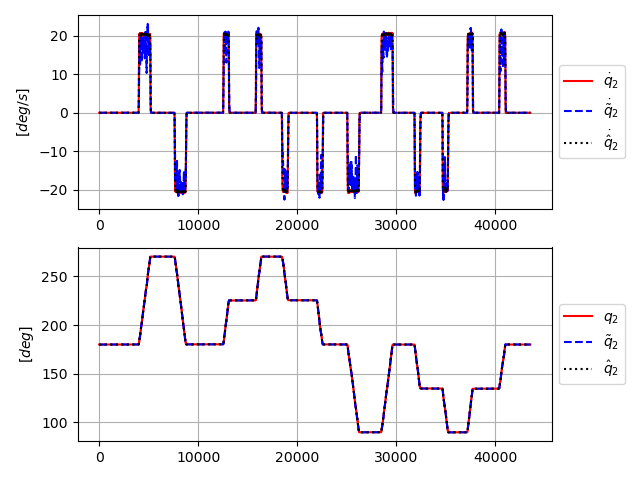

In [465]:
q2.values[0]=180
qdot2.values[0] = 0.0
dt=0.001
u = qdot2.values
x_hat = np.array([180, 0.]).T
z = np.array([q2.values, qdot2.values]).T
y2 = state_observer(x_hat,z,u,dt)
label1 = [r"$\dot{q}_2$",r"$\dot{\tilde{q}}_{2}$",r"$\dot{\hat{q}}_{2}$"]
label2 = [r"$q_2$",r"$\tilde{q}_{2}$",r"$\hat{q}_{2}$"]
plot_states(q2,qdot2, q2_kal, qdot2_kal, y2, label1, label2)

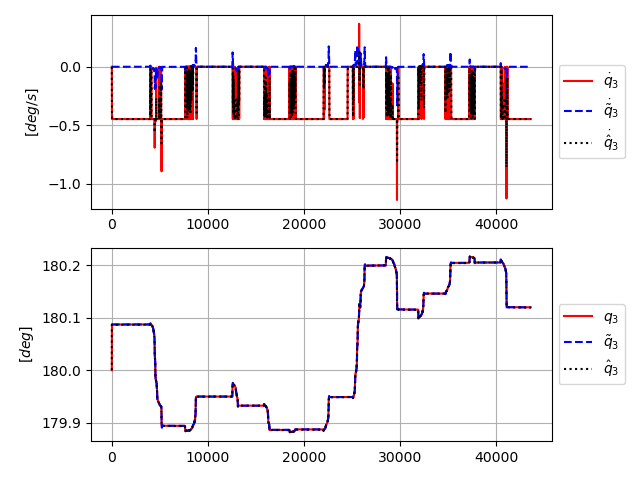

In [466]:
q3.values[0]=180
qdot3.values[0] = 0.0
dt=0.001
u = qdot3.values
x_hat = np.array([180, 0.]).T
z = np.array([q3.values, qdot3.values]).T
y3 = state_observer(x_hat,z,u,dt)
label1 = [r"$\dot{q}_3$",r"$\dot{\tilde{q}}_{3}$",r"$\dot{\hat{q}}_{3}$"]
label2 = [r"$q_3$",r"$\tilde{q}_{3}$",r"$\hat{q}_{3}$"]
plot_states(q3,qdot3, q3_kal, qdot3_kal, y3, label1, label2)

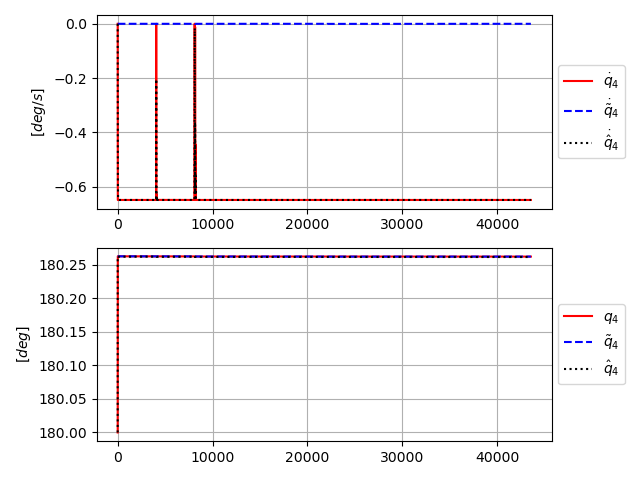

In [467]:
q4.values[0]=180
qdot4.values[0] = 0.0
dt=0.001
u = qdot4.values
x_hat = np.array([180, 0.]).T
z = np.array([q4.values, qdot4.values]).T
y4 = state_observer(x_hat,z,u,dt)
label1 = [r"$\dot{q}_4$",r"$\dot{\tilde{q}}_{4}$",r"$\dot{\hat{q}}_{4}$"]
label2 = [r"$q_4$",r"$\tilde{q}_{4}$",r"$\hat{q}_{4}$"]
plot_states(q4, qdot4, q4_kal, qdot4_kal, y4, label1, label2)

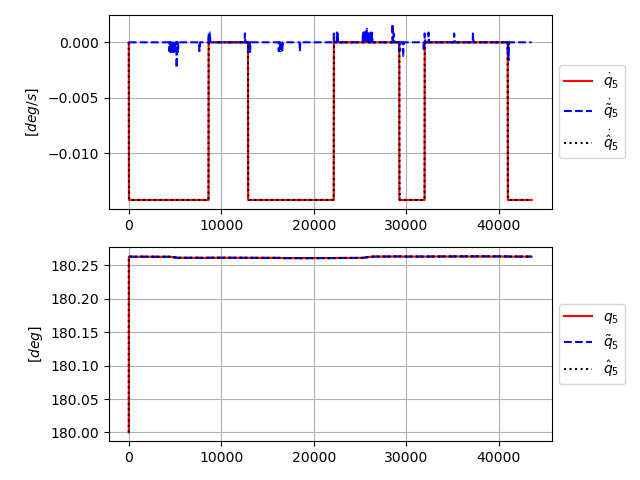

In [468]:
q5.values[0]=180
qdot5.values[0] = 0.0
dt=0.001
u = qdot5.values
x_hat = np.array([180, 0.]).T
z = np.array([q5.values, qdot5.values]).T
y5 = state_observer(x_hat,z,u,dt)
label1 = [r"$\dot{q}_5$",r"$\dot{\tilde{q}}_{5}$",r"$\dot{\hat{q}}_{5}$"]
label2 = [r"$q_5$",r"$\tilde{q}_{5}$",r"$\hat{q}_{5}$"]
plot_states(q5, qdot5, q5_kal, qdot5_kal, y5, label1, label2)

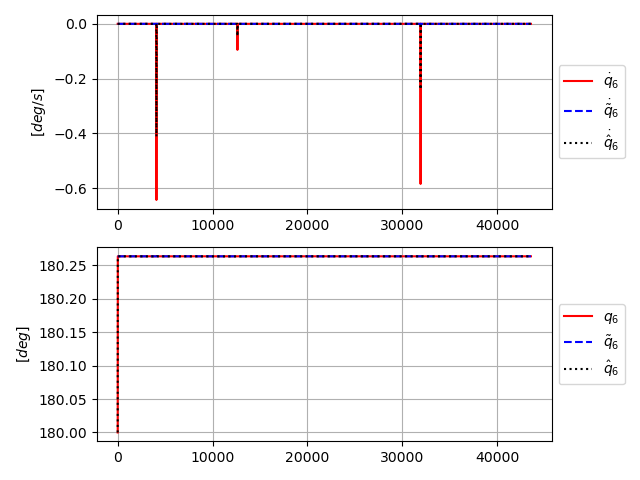

In [469]:
q6.values[0]=180
qdot6.values[0] = 0.0
dt=0.001
u = qdot6.values
x_hat = np.array([180, 0.]).T
z = np.array([q6.values, qdot6.values]).T
y6 = state_observer(x_hat,z,u,dt)
label1 = [r"$\dot{q}_6$",r"$\dot{\tilde{q}}_{6}$",r"$\dot{\hat{q}}_{6}$"]
label2 = [r"$q_6$",r"$\tilde{q}_{6}$",r"$\hat{q}_{6}$"]
plot_states(q6, qdot6, q6_kal, qdot6_kal, y6, label1, label2)